In [1]:
import numpy as np
import pyro
import pyro.distributions as dist

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
from scipy.stats import binom, beta, pareto
from sklearn.cluster import KMeans
import pickle

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1D Binomial mixture model

In [2]:
def binomial_lk(probs, DP, weights, K, NV):
    lk = torch.ones(K, len(NV)) # matrix with K rows and as many columns as the number of data
    if K == 1:
        return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(NV) # simply does log(weights) + log(density)
    for k in range(K):
        lk[k, :] = torch.log(weights[k]) + dist.Binomial(total_count=DP, probs=probs[k]).log_prob(NV) # put on each column of lk a different data; rows are the clusters
    return lk

def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters) to so obtain a single likelihood for each data

In [3]:
def binom_model(data, K):
    NV = data[:,0].int()
    DP = data[:,1].int()

    # prior for mixing proportions
    alpha = torch.ones(K)

    # Mixing proportions
    weights = pyro.sample("weights", dist.Dirichlet(alpha)) # i weights non vanno dentro al plate perchè l'output deve essere un vettore di elementi non indipendenti (perchè sommano a 1)

    # Prior for success probability of each binomial component
    with pyro.plate("plate_probs", K):
        probs = pyro.sample("probs", dist.Beta(1, 1)) # assume Beta prior for the binomial success probabilities
        # print(probs)

    # Plate for the data
    with pyro.plate("plate_data", len(data)):
        pyro.factor("lik", log_sum_exp(binomial_lk(probs, DP, weights, K, NV)).sum()) # .sum() sums over the data because we have a log-likelihood

In [4]:
def binom_guide(data, K):

    # Mixing proportions
    # in pyro.param usa .sample() perchè non vuole semplicemente la prior ma vuole dei sample.
    weights_param = pyro.param("weights_param", lambda: dist.Dirichlet(torch.ones(K)).sample(), constraint=constraints.simplex)
    weights = pyro.sample("weights", dist.Delta(weights_param).to_event(1))

    # Probabilities of success with Beta(1,1) prior
    probs_param = pyro.param("probs_param", dist.Beta(torch.ones(K), torch.ones(K)).sample(), constraint=constraints.interval(0.,1.))
    print(probs_param)
    
    # Probability of success for each component
    with pyro.plate("plate_probs", K):
        pyro.sample("probs", dist.Delta(probs_param))

In [5]:
# Create the dataset with two binomial components
# data: [NV, DP]
g1 = torch.ones([100, 2]) * 100 # 33% data from binomial 1
g2 = torch.ones([200, 2]) * 200 # 66% data from binomial 2

In [6]:
g1[:,0] = dist.Binomial(total_count=100, probs=torch.tensor([.2])).sample([100]).squeeze(-1)
g2[:,0] = dist.Binomial(total_count=200, probs=torch.tensor([.6])).sample([200]).squeeze(-1)
d_example = torch.concat((g1,g2))
# d_example

In [8]:
# Run inference
pyro.clear_param_store()
svi = pyro.infer.SVI(binom_model, binom_guide, pyro.optim.Adam({"lr": 0.001}), pyro.infer.TraceGraph_ELBO())
num_iterations = 2000
for i in range(num_iterations):
    loss = svi.step(d_example, K=2)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

tensor([0.3384, 0.1066], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 2220544.0
tensor([0.3386, 0.1067], grad_fn=<ClampBackward1>)
tensor([0.3388, 0.1068], grad_fn=<ClampBackward1>)
tensor([0.3390, 0.1069], grad_fn=<ClampBackward1>)
tensor([0.3393, 0.1070], grad_fn=<ClampBackward1>)
tensor([0.3395, 0.1071], grad_fn=<ClampBackward1>)
tensor([0.3397, 0.1072], grad_fn=<ClampBackward1>)
tensor([0.3399, 0.1073], grad_fn=<ClampBackward1>)
tensor([0.3402, 0.1074], grad_fn=<ClampBackward1>)
tensor([0.3404, 0.1075], grad_fn=<ClampBackward1>)
tensor([0.3406, 0.1076], grad_fn=<ClampBackward1>)
tensor([0.3408, 0.1077], grad_fn=<ClampBackward1>)
tensor([0.3411, 0.1078], grad_fn=<ClampBackward1>)
tensor([0.3413, 0.1079], grad_fn=<ClampBackward1>)
tensor([0.3415, 0.1080], grad_fn=<ClampBackward1>)
tensor([0.3417, 0.1081], grad_fn=<ClampBackward1>)
tensor([0.3420, 0.1082], grad_fn=<ClampBackward1>)
tensor([0.3422, 0.1083], grad_fn=<ClampBackward1>)
tensor([0.3424, 0.1084], grad_fn=<ClampBackward1>)
t

In [9]:
# Print learned parameters
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.6659, 0.3341], grad_fn=<DivBackward0>)
probs_param tensor([0.5978, 0.2104], grad_fn=<ClampBackward1>)


In [11]:
# Extract learned parameters
probs = pyro.param("probs_param").detach().numpy()
weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success: ", probs)
print("Mmixing proportions: ", weights)

Probabilities of success:  [0.5977877  0.21039617]
Mmixing proportions:  [0.6659246 0.3340754]


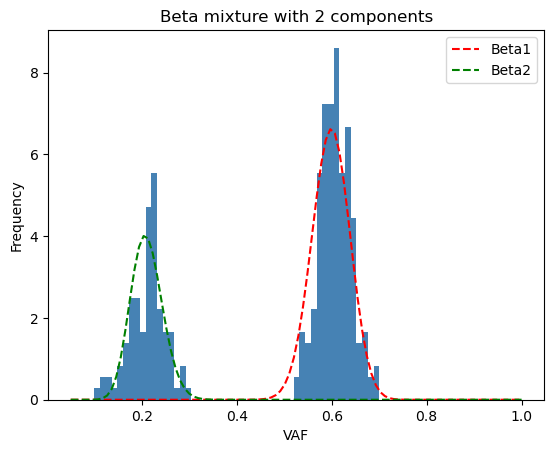

In [16]:
# Plot histogram of data
VAF = d_example[:,0]/d_example[:,1]
plt.hist(VAF, bins=50, density = True, color='steelblue')

# Plot densities
x = np.linspace(0.05, 1, 100)
num_components = 2
n = 150

density1 = beta.pdf(x, n*probs[0], n*(1-probs[0])) * weights[0] # sample data from beta distribution with learned parameters
plt.plot(x, density1, linewidth=1.5, label=f'Beta1', linestyle='--', color='r')
density2 = beta.pdf(x, n*probs[1], n*(1-probs[1])) * weights[1] # sample data from beta distribution with learned parameters
plt.plot(x, density2, linewidth=1.5, label=f'Beta2', linestyle='--', color='g')

plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.title("Beta mixture with 2 components")
plt.legend()
plt.show()

### 1D Binomial Pareto model

In [2]:
# Load pkl data
# These data contains a mixture with 1 Pareto and 2 beta components 
def load_example_data(directory = "./"):
    flh = open(directory + "example.pkl", "rb")
    inp = pickle.load(flh)
    inp = {k: v.float().round() for k, v in zip(inp.keys(), inp.values())}
    return inp

In [3]:
data = load_example_data("./")
len(data["1:1"])

961

In [4]:
data

{'1:1': tensor([[  7., 112.],
         [  6., 101.],
         [  7., 106.],
         ...,
         [ 47., 114.],
         [ 64., 121.],
         [ 66., 138.]])}

In [5]:
data = data["1:1"]

In [6]:
data

tensor([[  7., 112.],
        [  6., 101.],
        [  7., 106.],
        ...,
        [ 47., 114.],
        [ 64., 121.],
        [ 66., 138.]])

In [34]:
data.shape

torch.Size([961, 2])

In [105]:
def binomial_lk(probs, DP, weights, K, NV):
    lk = torch.ones(K, len(NV)) # matrix with K rown and as many columns as the number of data
    if K == 1:
        return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(NV) # simply does log(weights) + log(density)
    for k in range(K):
        lk[k, :] = torch.log(weights[k]) + dist.Binomial(total_count=DP, probs=probs[k]).log_prob(NV) # put on each column of lk a different data; rows are the clusters
    return lk

def pareto_lk(p, NV, DP):
    return dist.Binomial(probs=p, total_count=DP).log_prob(NV)

def final_lk(pareto, binomial, weights):
    if len(binomial.shape) == 1:
        dim0, dim1 = 1,binomial.shape[0] # dim0 is the number of beta peaks, dim1 is the number of data (mutations) -> this comes from the binomial_lk() function
    else:
        dim0, dim1 = binomial.shape[0], binomial.shape[1]
    # print(dim0, dim1)
    
    lk = torch.ones(1 + dim0, dim1) # creates a matrix: rows with number of binomial peaks+1 (pareto), columns with data.
                                    # So the rows will represent the components (with correspondent weights) and the columns represent the data
    lk[0, :] = torch.log(weights[0]) + pareto
    # print(weights[1:].shape, binomial.shape)

    w_sum = weights[1:].sum()
    lk[1:(1 + dim1), :] = torch.log(w_sum) + binomial.unsqueeze(0)
    # lk[1:(1 + dim1), :] = torch.log(weights[1:]) + binomial
    return lk


def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

In [106]:
from pyro.distributions import Rejector, Pareto
# Rejector: Rejection sampled distribution given an acceptance rate function.

# BoundedPareto taken form MOBSTERH
class BoundedPareto(Rejector):
    def __init__(self, scale, alpha, upper_limit, validate_args=False):
        propose = Pareto(scale, alpha, validate_args=validate_args)

        def log_prob_accept(x):
            return (x <= upper_limit).type_as(x).log()
        # log_prob_accept: This is a function that computes the logarithm of the acceptance probability for a given value x. 
        # It checks if x is less than or equal to the upper_limit. 
        # If x is within the specified range, the function returns the log of 1 (acceptance probability is 1). 
        # Otherwise, it returns the log of 0 (acceptance probability is 0).

        # log_scale = torch.Tensor(alpha) * torch.log(torch.Tensor([scale / upper_limit]))
        log_scale = 0
        super(BoundedPareto, self).__init__(propose, log_prob_accept, log_scale)

In [107]:
def binom_pareto_model(data, K):
    NV = data[:,0].int()
    DP = data[:,1].int()
    VAF = NV/DP 

    # prior for Pareto shape parameter (alpha_pareto)
    alpha = pyro.sample("alpha_pareto", dist.LogNormal(0,100))
    probs_pareto = pyro.sample("probs_pareto", BoundedPareto(torch.min(VAF) - 1e-5, alpha, 1))
    # probs_pareto = pyro.sample("probs_pareto", dist.Pareto(torch.min(VAF) - 1e-5, alpha))

    weights = pyro.sample("weights", dist.Dirichlet(torch.ones(K+1)))

    # Prior for success probability of each component
    with pyro.plate("plate_probs", K):
        probs = pyro.sample("probs", dist.Beta(1, 1)) # assume Beta prior for the success probabilities
        # print(probs)

    # Plate for the data
    with pyro.plate("plate_data", len(data)):
        binomial = binomial_lk(probs, DP, weights[1:], K, NV)
        pareto = pareto_lk(probs_pareto, NV, DP)
        pyro.factor("lik", log_sum_exp(final_lk(pareto, binomial, weights)).sum()) # .sum() sums over the data because we have a log-likelihood


In [108]:
def binom_pareto_guide(data, K):
    NV = data[:,0].int()
    DP = data[:,1].int()
    VAF = NV/DP
    
    # Mixing proportions to be learned
    weights_param = pyro.param("weights_param", lambda: dist.Dirichlet(torch.ones(K+1)).sample(), constraint=constraints.simplex)
    weights = pyro.sample("weights", dist.Delta(weights_param).to_event(1))

    probs_param = pyro.param("probs_param", dist.Beta(torch.ones(K), torch.ones(K)).sample(), constraint=constraints.interval(0.,1.))

    # Pareto
    # alpha_param = pyro.param("alpha_param", dist.LogNormal(0,100).sample(), constraint=constraints.positive) # with LogNormal it does not work, check
    alpha_param = pyro.param("alpha_param", torch.tensor(0.8), constraint=constraints.positive) # Use 0.8 as starting value
    pyro.sample("alpha_pareto", dist.Delta(alpha_param))
    
    # Using param for this probability it does not learn the right parameters, I do not know why
    # probs_pareto_param = pyro.param("probs_pareto_param", BoundedPareto(torch.min(VAF) - 1e-5, alpha_param, 1).sample(), constraint=constraints.interval(0.,1.))
    # pyro.sample("probs_pareto", dist.Delta(probs_pareto_param))
    pyro.sample("probs_pareto", BoundedPareto(torch.min(VAF) - 1e-5, alpha_param, 1))
    
    # Probability of success for each beta component
    with pyro.plate("plate_probs", K):
        pyro.sample("probs", dist.Delta(probs_param))

In [109]:
# Run inference
pyro.clear_param_store()
svi = pyro.infer.SVI(binom_pareto_model, binom_pareto_guide, pyro.optim.Adam({"lr": 0.01}), pyro.infer.TraceGraph_ELBO())
num_iterations = 3000
for i in range(num_iterations):
    loss = svi.step(data, K=1)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

Iteration 0: Loss = 24183418.0
Iteration 100: Loss = 38402016.0
Iteration 200: Loss = 16382365.0
Iteration 300: Loss = 7076681.5
Iteration 400: Loss = 4741486.0
Iteration 500: Loss = 5123930.0
Iteration 600: Loss = 4368314.5
Iteration 700: Loss = 4369308.5
Iteration 800: Loss = 4719802.5
Iteration 900: Loss = 4915904.5
Iteration 1000: Loss = 5064776.0
Iteration 1100: Loss = 18452452.0
Iteration 1200: Loss = 5000326.0
Iteration 1300: Loss = 5299770.5
Iteration 1400: Loss = 4407922.0
Iteration 1500: Loss = 5112594.5
Iteration 1600: Loss = 4912262.5
Iteration 1700: Loss = 4898350.5
Iteration 1800: Loss = 5337990.5
Iteration 1900: Loss = 5411963.0
Iteration 2000: Loss = 5089210.5
Iteration 2100: Loss = 4327175.5
Iteration 2200: Loss = 4529639.0
Iteration 2300: Loss = 4769827.5
Iteration 2400: Loss = 5284553.5
Iteration 2500: Loss = 4761371.5
Iteration 2600: Loss = 4307914.5
Iteration 2700: Loss = 4380011.5
Iteration 2800: Loss = 4912142.5
Iteration 2900: Loss = 5358834.5


In [110]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.2457, 0.7543], grad_fn=<DivBackward0>)
probs_param tensor([0.4624], grad_fn=<ClampBackward1>)
alpha_param tensor(3.0759, grad_fn=<AddBackward0>)


In [111]:
# Extract the learned parameters
probs_bin = pyro.param("probs_param").detach().numpy()
alpha_pareto = pyro.param("alpha_param").detach().numpy() 
weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success binomial component: ", probs_bin)
print("Alpha pareto: ", alpha_pareto)
print("Mmixing proportions: ", weights)

Probabilities of success binomial component:  [0.4623797]
Alpha pareto:  3.0759087
Mmixing proportions:  [0.24574329 0.7542567 ]


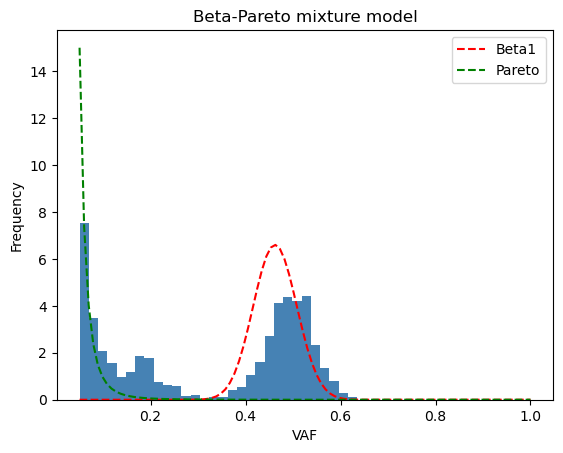

In [114]:
# Plot histogram of data
NV = data[:,0]
DP = data[:,1]
VAF = NV/DP
plt.hist(VAF, bins=30, density=True, color='steelblue')

# Plot densities
x = np.linspace(torch.min(VAF), 1, 100)
num_components = 2
n = torch.mean(DP)

density1 = beta.pdf(x, n*probs_bin[0], n*(1-probs_bin[0])) * weights[1]
plt.plot(x, density1, linewidth=1.5, label=f'Beta1', linestyle='--', color='r')
density2 = pareto.pdf(x, alpha_pareto, scale = torch.min(VAF)) * weights[0]
plt.plot(x, density2, linewidth=1.5, label=f'Pareto', linestyle='--', color='g')

plt.title("Beta-Pareto mixture model")
plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Using K=2

In [115]:
# Run inference
pyro.clear_param_store()
# svi = pyro.infer.SVI(binom_model, binom_guide, pyro.optim.Adam({"lr": 0.001}), pyro.infer.TraceEnum_ELBO())
svi = pyro.infer.SVI(binom_pareto_model, binom_pareto_guide, pyro.optim.Adam({"lr": 0.01}), pyro.infer.TraceGraph_ELBO())
num_iterations = 3000
for i in range(num_iterations):
    loss = svi.step(data, K=2)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

Iteration 0: Loss = 12135873.0
Iteration 100: Loss = 5437715.0
Iteration 200: Loss = 4983635.0
Iteration 300: Loss = 4991059.5
Iteration 400: Loss = 7214270.0
Iteration 500: Loss = 4057910.5
Iteration 600: Loss = 4157029.0
Iteration 700: Loss = 3780703.25
Iteration 800: Loss = 3729275.5
Iteration 900: Loss = 3719068.25
Iteration 1000: Loss = 3730468.75
Iteration 1100: Loss = 4717405.0
Iteration 1200: Loss = 3740127.75
Iteration 1300: Loss = 3810319.0
Iteration 1400: Loss = 3761866.75
Iteration 1500: Loss = 3797735.75
Iteration 1600: Loss = 3769837.0
Iteration 1700: Loss = 3795896.25
Iteration 1800: Loss = 3776173.5
Iteration 1900: Loss = 3759757.5
Iteration 2000: Loss = 3808933.75
Iteration 2100: Loss = 3714008.75
Iteration 2200: Loss = 3719598.0
Iteration 2300: Loss = 3715442.75
Iteration 2400: Loss = 3743003.25
Iteration 2500: Loss = 3789244.25
Iteration 2600: Loss = 3749779.75
Iteration 2700: Loss = 3748694.5
Iteration 2800: Loss = 3740845.0
Iteration 2900: Loss = 3788058.5


In [116]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.1447, 0.2189, 0.6364], grad_fn=<DivBackward0>)
probs_param tensor([0.1781, 0.4926], grad_fn=<ClampBackward1>)
alpha_param tensor(5.0964, grad_fn=<AddBackward0>)


In [117]:
# Extract the learned parameters
probs_bin = pyro.param("probs_param").detach().numpy()
alpha_pareto = pyro.param("alpha_param").detach().numpy() 
weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success binomial component: ", probs_bin)
print("Alpha pareto: ", alpha_pareto)
print("Mixing proportions: ", weights)

Probabilities of success binomial component:  [0.17814167 0.49264684]
Alpha pareto:  5.0964003
Mixing proportions:  [0.14466944 0.21890073 0.6364298 ]


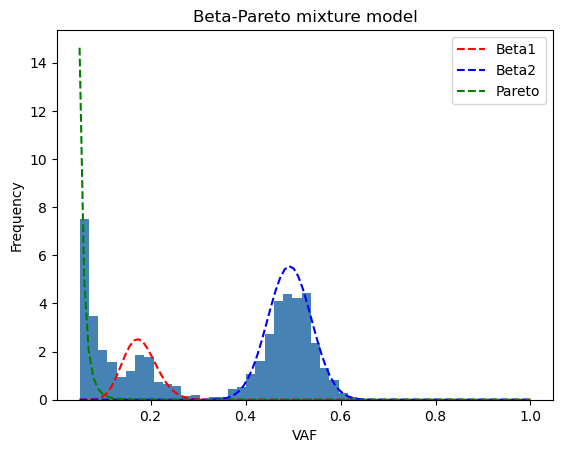

In [119]:
# Plot histogram of data
NV = data[:,0]
DP = data[:,1]
VAF = NV/DP
plt.hist(VAF, bins=30, density=True, color='steelblue')

# Plot densities
x = np.linspace(torch.min(VAF), 1, 100)
n = torch.mean(DP)

# Sample from beta and pareto distributions with the learned parameters
density1 = beta.pdf(x, n*probs_bin[0], n*(1-probs_bin[0])) * weights[1]
plt.plot(x, density1, linewidth=1.5, label=f'Beta1', linestyle='--', color='r')
density2 = beta.pdf(x, n*probs_bin[1], n*(1-probs_bin[1])) * weights[2]
plt.plot(x, density2, linewidth=1.5, label=f'Beta2', linestyle='--', color='b')
density_pareto = pareto.pdf(x, alpha_pareto, scale = torch.min(VAF)) * weights[0]
plt.plot(x, density_pareto, linewidth=1.5, label=f'Pareto', linestyle='--', color='g')

plt.title("Beta-Pareto mixture model")
plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Multidimensional binomial model

In [227]:
# Create the dataset
# NV : [NV_s1, NV_s2]
# DP : : [DP_s1, DP_s2]
# DP is fixed inside the model
seed = 123
pyro.set_rng_seed(seed)
d1 = torch.ones([1000, 2])
d2 = torch.ones([2000, 2])

In [228]:
pyro.set_rng_seed(seed)
d1[:,0] = dist.Binomial(total_count=100, probs=torch.tensor([.1])).sample([1000]).squeeze(-1) # S1 for component 1
d1[:,1] = dist.Binomial(total_count=100, probs=torch.tensor([.3])).sample([1000]).squeeze(-1) # S2 for component 1

d2[:,0] = dist.Binomial(total_count=150, probs=torch.tensor([.5])).sample([2000]).squeeze(-1) # S1 for component 2
d2[:,1] = dist.Binomial(total_count=150, probs=torch.tensor([.6])).sample([2000]).squeeze(-1) # S2 for component 2

NV = torch.concat((d1,d2))
print(NV.shape)
NV

torch.Size([3000, 2])


tensor([[ 9., 33.],
        [11., 31.],
        [10., 34.],
        ...,
        [80., 93.],
        [66., 94.],
        [74., 91.]])

In [4]:
DP1 = torch.ones([1000, 2]) * 100
DP2 = torch.ones([2000, 2]) * 150
DP = torch.concat((DP1,DP2))
print(DP.shape)
DP

torch.Size([3000, 2])


tensor([[100., 100.],
        [100., 100.],
        [100., 100.],
        ...,
        [150., 150.],
        [150., 150.],
        [150., 150.]])

In [5]:
# # Shuffle elements
# idx = torch.randperm(NV.shape[0])
# NV = NV[idx]
# DP = DP[idx]
# NV

In [6]:
print(100*0.2)
print(150*.6)

20.0
90.0


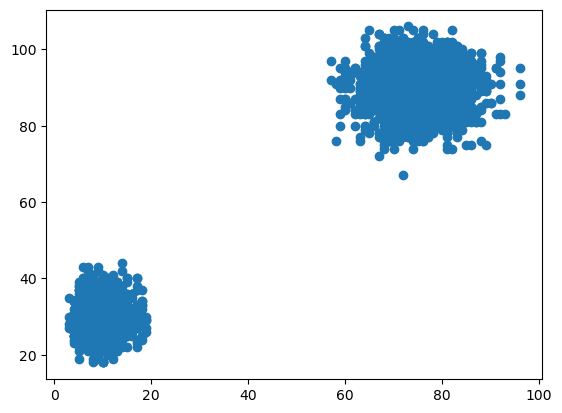

In [7]:
# Plot the data
plt.scatter(NV[:,0], NV[:,1])

Text(0.5, 1.0, 'VAF 2d spectrum')

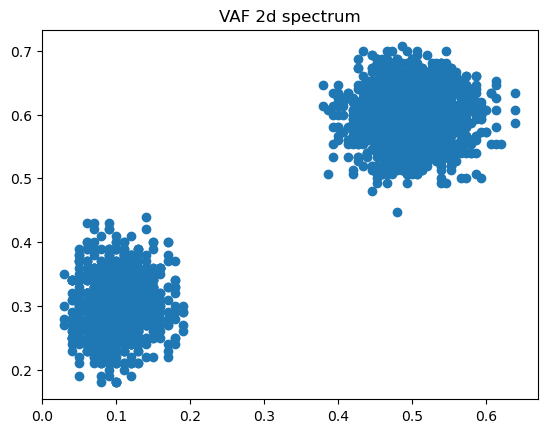

In [8]:
# Plot normalized data (as they were the VAF)
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])
plt.title("VAF 2d spectrum")

For kmeans I need to find the best value of K in order to initialize in the best way the parameter p.

In [9]:
kmeans = KMeans(n_clusters=2, random_state=seed, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [10]:
cluster_centers = torch.tensor(cluster_centers)#.float().detach()
print(cluster_centers)

tensor([[0.4996, 0.6000],
        [0.1007, 0.3026]])


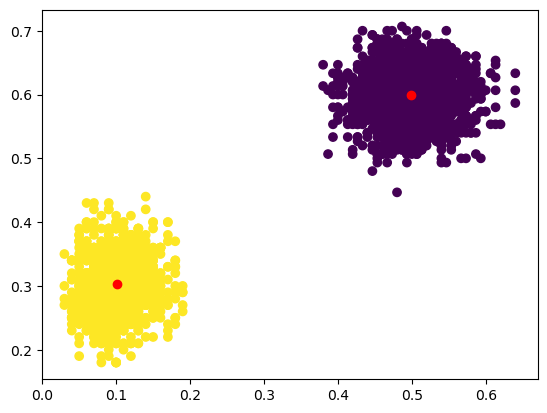

In [11]:
NV_S1 = NV[:,0]
NV_S2 = NV[:,1]

DP_S1 = DP[:,0]
DP_S2 = DP[:,1]
plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c = cluster, label = "Original data")
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c = 'r')

In [12]:
# Rewrite binomial likelihood for the multidimensional case
# Multidimensional binomial log likelihood
def m_binomial_lk(probs, DP, weights, K, NV):
    lk = torch.ones(K, len(NV)) # matrix with K rows and as many columns as the number of data
    if K == 1:
        return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(NV).sum(axis=1) # simply does log(weights) + log(density)
    for k in range(K):
        lk[k, :] = torch.log(weights[k]) + dist.Binomial(total_count=DP, probs=probs[k, :]).log_prob(NV).sum(axis=1) # sums over the data dimensions (columns)
                                                                                                                 # put on each column of lk a different data; rows are the clusters
    return lk

def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

In [15]:
def m_binom_model(NV, DP, K):
    # NV = data
    # DP = 150 # al momento lo fisso qui, poi sarà preso dai dati
    D = NV.shape[1] # number of dimensions (samples)

    # Prior for the mixing weights
    weights = pyro.sample("weights", dist.Dirichlet(torch.ones(K)))

    # Prior for success probabilities (each probability has 2 dimensions) for each component
    with pyro.plate("plate_dims", D):
        # probs = pyro.sample("probs", dist.Beta(1, 1).expand([D]).to_event(1)) # assume Beta prior for the success probabilities
        with pyro.plate("plate_probs", K):
            probs = pyro.sample("probs", dist.Beta(1, 1)) # assume Beta prior for the success probabilities
            # with this order of plates we obtain a tensor K x D
        # probs = pyro.sample("probs", dist.Beta(torch.ones(K, d), torch.ones(K, d)))
    # print(probs)

    # Data generation
    with pyro.plate("plate_data", len(NV)):
        pyro.factor("lik", log_sum_exp(m_binomial_lk(probs, DP, weights, K, NV)).sum()) # .sum() sums over the data because we have a log-likelihood

In [16]:
def m_binom_guide(NV, DP, K):
    D = NV.shape[1] # number of dimensions (samples)
    
    weights_param = pyro.param("weights_param", lambda: dist.Dirichlet(torch.ones(K)).sample(), constraint=constraints.simplex)
    pyro.sample("weights", dist.Delta(weights_param).to_event(1))

    # probs_param = pyro.param("probs_param", dist.Beta(torch.ones(K, D), torch.ones(K,D)).sample(), constraint=constraints.interval(0.,1.))
    probs_param = pyro.param("probs_param", cluster_centers, constraint=constraints.interval(0.,1.))
    
    print(probs_param)
    
    # Probability of success for each component
    # with pyro.plate("plate_probs", K):
    #     pyro.sample("probs", dist.Delta(probs_param).to_event(1))
    with pyro.plate("plate_dims", D):
        with pyro.plate("plate_probs", K):
            pyro.sample("probs", dist.Delta(probs_param))

In [17]:
# Run inference
pyro.clear_param_store()
seed = 123
pyro.set_rng_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
svi = pyro.infer.SVI(m_binom_model, m_binom_guide, pyro.optim.Adam({"lr": 0.001}), pyro.infer.TraceGraph_ELBO())
num_iterations = 2000
for i in range(num_iterations):
    loss = svi.step(NV, DP, K=2)
    if i % 200 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

tensor([[0.4996, 0.6000],
        [0.1007, 0.3026]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 61479336.0
tensor([[0.4998, 0.6002],
        [0.1006, 0.3029]], grad_fn=<ClampBackward1>)
tensor([[0.4996, 0.6000],
        [0.1007, 0.3027]], grad_fn=<ClampBackward1>)
tensor([[0.4994, 0.5999],
        [0.1007, 0.3025]], grad_fn=<ClampBackward1>)
tensor([[0.4994, 0.5998],
        [0.1008, 0.3025]], grad_fn=<ClampBackward1>)
tensor([[0.4994, 0.5998],
        [0.1008, 0.3025]], grad_fn=<ClampBackward1>)
tensor([[0.4995, 0.5999],
        [0.1007, 0.3026]], grad_fn=<ClampBackward1>)
tensor([[0.4996, 0.6000],
        [0.1007, 0.3026]], grad_fn=<ClampBackward1>)
tensor([[0.4996, 0.6001],
        [0.1007, 0.3027]], grad_fn=<ClampBackward1>)
tensor([[0.4997, 0.6001],
        [0.1007, 0.3027]], grad_fn=<ClampBackward1>)
tensor([[0.4997, 0.6001],
        [0.1007, 0.3027]], grad_fn=<ClampBackward1>)
tensor([[0.4997, 0.6001],
        [0.1007, 0.3027]], grad_fn=<ClampBackward1>)
tensor([[0.4996, 0.60

In [18]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.6667, 0.3333], grad_fn=<DivBackward0>)
probs_param tensor([[0.4996, 0.6000],
        [0.1007, 0.3026]], grad_fn=<ClampBackward1>)


In [19]:
# Extract the learned parameters
param_store = pyro.get_param_store()
params = {}
params["probs_bin"] = param_store["probs_param"].clone().detach()
params["weights"] = param_store["weights_param"].clone().detach()

# probs_bin = pyro.param("probs_param").detach().numpy()
# weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success binomial component: ", params["probs_bin"]) # First row = component 1, second row = component 2
print("Mixing proportions: ", params["weights"])

Probabilities of success binomial component:  tensor([[0.4996, 0.6000],
        [0.1007, 0.3026]])
Mixing proportions:  tensor([0.6667, 0.3333])


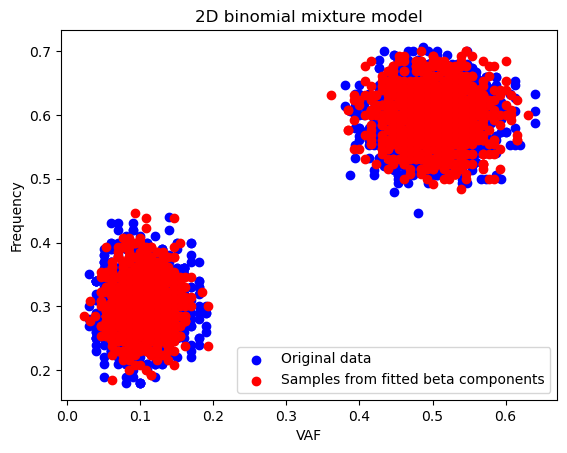

In [22]:
# Plot histogram of data

# DP = 130
NV_S1 = NV[:,0]
NV_S2 = NV[:,1]

DP_S1 = DP[:,0]
DP_S2 = DP[:,1]
plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c = 'b', label = "Original data")

# Plot samples from fitted densities
x = np.linspace(0, 150, 1000)
n = 130

f1 = torch.ones([1000, 2])
f1[:,0] = dist.Binomial(total_count=n, probs=params["probs_bin"][0,0]).sample([1000]).squeeze(-1)
f1[:,1] = dist.Binomial(total_count=n, probs=params["probs_bin"][0,1]).sample([1000]).squeeze(-1)
plt.scatter(f1[:,0]/n, f1[:,1]/n, c = 'r', label = "Samples from fitted beta components")

f2 = torch.ones([1000, 2])
f2[:,0] = dist.Binomial(total_count=n, probs=params["probs_bin"][1,0]).sample([1000]).squeeze(-1)
f2[:,1] = dist.Binomial(total_count=n, probs=params["probs_bin"][1,1]).sample([1000]).squeeze(-1)
plt.scatter(f2[:,0]/n, f2[:,1]/n, c = 'r')

plt.title('2D binomial mixture model')
plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [21]:
K = 2

In [138]:
# Now compute posterior assignment probabilities given the learned parameters
lks = m_binomial_lk(probs=params['probs_bin'], DP = DP, weights=params['weights'], K = K, NV = NV) # Compute log-likelihood for each data in each cluster
res = torch.zeros(K, len(NV))

In [139]:
norm_fact = log_sum_exp(lks) # sums over the different cluster -> array of size len(NV)
for k in range(len(res)): # iterate over the clusters
    lks_k = lks[k] # take row k -> array of size len(NV)
    res[k] = torch.exp(lks_k - norm_fact)
params["cluster_probs"] = res

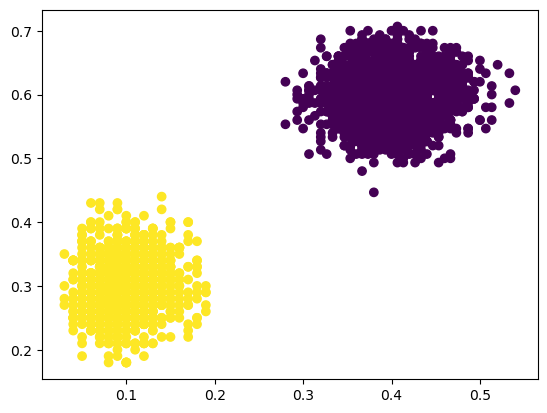

In [140]:
clust =  torch.argmax(params["cluster_probs"], dim = 0)
NV_S1 = NV[:,0]
NV_S2 = NV[:,1]

DP_S1 = DP[:,0]
DP_S2 = DP[:,1]
plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c = clust, label = "Original data")

Trying with a different seed

In [141]:
# Run inference
pyro.clear_param_store()
seed = 30
pyro.set_rng_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
svi = pyro.infer.SVI(m_binom_model, m_binom_guide, pyro.optim.Adam({"lr": 0.001}), pyro.infer.TraceGraph_ELBO())
num_iterations = 5000
for i in range(num_iterations):
    loss = svi.step(NV, DP, K=2)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

g : tensor([[0.3997, 0.6000],
        [0.1007, 0.3026]], grad_fn=<ClampBackward1>)
tensor([[0.3997, 0.6000],
        [0.1007, 0.3026]], grad_fn=<ExpandBackward0>)
Iteration 0: Loss = 63489756.0
g : tensor([[0.3999, 0.5997],
        [0.1006, 0.3029]], grad_fn=<ClampBackward1>)
tensor([[0.3999, 0.5997],
        [0.1006, 0.3029]], grad_fn=<ExpandBackward0>)
g : tensor([[0.3997, 0.5999],
        [0.1007, 0.3027]], grad_fn=<ClampBackward1>)
tensor([[0.3997, 0.5999],
        [0.1007, 0.3027]], grad_fn=<ExpandBackward0>)
g : tensor([[0.3996, 0.6001],
        [0.1007, 0.3025]], grad_fn=<ClampBackward1>)
tensor([[0.3996, 0.6001],
        [0.1007, 0.3025]], grad_fn=<ExpandBackward0>)
g : tensor([[0.3995, 0.6001],
        [0.1008, 0.3025]], grad_fn=<ClampBackward1>)
tensor([[0.3995, 0.6001],
        [0.1008, 0.3025]], grad_fn=<ExpandBackward0>)
g : tensor([[0.3995, 0.6001],
        [0.1008, 0.3025]], grad_fn=<ClampBackward1>)
tensor([[0.3995, 0.6001],
        [0.1008, 0.3025]], grad_fn=<ExpandBac

In [142]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.6667, 0.3333], grad_fn=<DivBackward0>)
probs_param tensor([[0.3997, 0.6000],
        [0.1007, 0.3026]], grad_fn=<ClampBackward1>)


In [143]:
# Extract the learned parameters
param_store = pyro.get_param_store()
params = {}
params["probs_bin"] = param_store["probs_param"].clone().detach()
params["weights"] = param_store["weights_param"].clone().detach()

# probs_bin = pyro.param("probs_param").detach().numpy()
# weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success binomial component: ", params["probs_bin"]) # First row = component 1, second row = component 2
print("Mixing proportions: ", params["weights"])

Probabilities of success binomial component:  tensor([[0.3997, 0.6000],
        [0.1007, 0.3026]])
Mixing proportions:  tensor([0.6667, 0.3333])


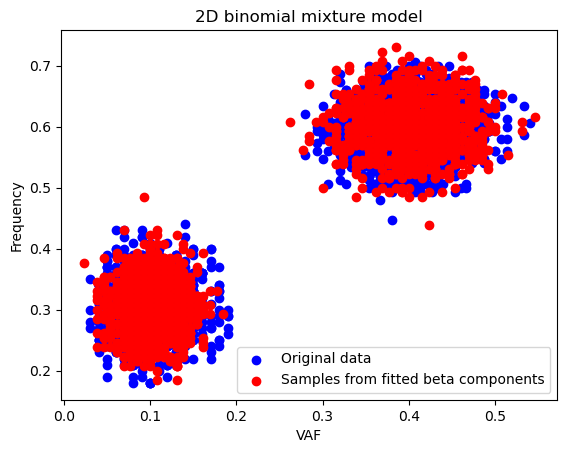

In [144]:
# Plot histogram of data

# DP = 130
NV_S1 = NV[:,0]
NV_S2 = NV[:,1]

DP_S1 = DP[:,0]
DP_S2 = DP[:,1]
plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c = 'b', label = "Original data")

# Plot samples from fitted densities
x = np.linspace(0, 150, 1000)
n = 130

f1 = torch.ones([1000, 2])
f1[:,0] = dist.Binomial(total_count=n, probs=params["probs_bin"][0,0]).sample([1000]).squeeze(-1)
f1[:,1] = dist.Binomial(total_count=n, probs=params["probs_bin"][0,1]).sample([1000]).squeeze(-1)
plt.scatter(f1[:,0]/n, f1[:,1]/n, c = 'r', label = "Samples from fitted beta components")

f2 = torch.ones([1000, 2])
f2[:,0] = dist.Binomial(total_count=n, probs=params["probs_bin"][1,0]).sample([1000]).squeeze(-1)
f2[:,1] = dist.Binomial(total_count=n, probs=params["probs_bin"][1,1]).sample([1000]).squeeze(-1)
plt.scatter(f2[:,0]/n, f2[:,1]/n, c = 'r')

plt.title('2D binomial mixture model')
plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [20]:
K = 2

In [21]:
# Now compute posterior assignment probabilities given the learned parameters
lks = m_binomial_lk(probs=params['probs_bin'], DP = DP, weights=params['weights'], K = K, NV = NV) # Compute log-likelihood for each data in each cluster
res = torch.zeros(K, len(NV))

In [22]:
norm_fact = log_sum_exp(lks) # sums over the different cluster -> array of size len(NV)
for k in range(len(res)): # iterate over the clusters
    lks_k = lks[k] # take row k -> array of size len(NV)
    res[k] = torch.exp(lks_k - norm_fact)
params["cluster_probs"] = res

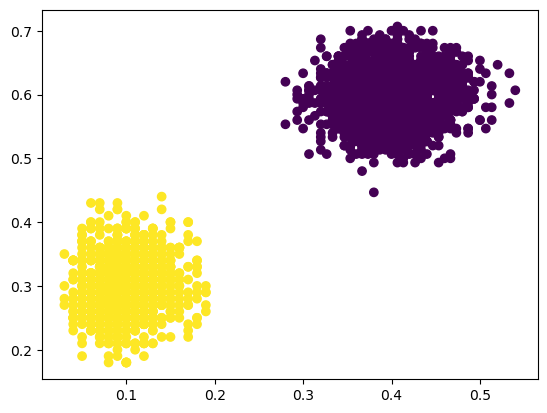

In [23]:
clust =  torch.argmax(params["cluster_probs"], dim = 0)
NV_S1 = NV[:,0]
NV_S2 = NV[:,1]

DP_S1 = DP[:,0]
DP_S2 = DP[:,1]
plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c = clust, label = "Original data")

### Trying a 2D Beta-Pareto model

In [2]:
from pyro.distributions import Rejector, Pareto
# Rejector: Rejection sampled distribution given an acceptance rate function.

# BoundedPareto taken form MOBSTERH
class BoundedPareto(Rejector):
    def __init__(self, scale, alpha, upper_limit, validate_args=False):
        propose = Pareto(scale, alpha, validate_args=validate_args)

        def log_prob_accept(x):
            return (x <= upper_limit).type_as(x).log()
        # log_prob_accept: This is a function that computes the logarithm of the acceptance probability for a given value x. 
        # It checks if x is less than or equal to the upper_limit. 
        # If x is within the specified range, the function returns the log of 1 (acceptance probability is 1). 
        # Otherwise, it returns the log of 0 (acceptance probability is 0).

        # log_scale = torch.Tensor(alpha) * torch.log(torch.Tensor([scale / upper_limit]))
        log_scale = 0
        super(BoundedPareto, self).__init__(propose, log_prob_accept, log_scale)

In [3]:
seed = 123
pyro.set_rng_seed(seed)
N1 = 1000  # Number of samples in component 1
N2 = 2000  # Number of samples in component 2
d1 = torch.ones([N1, 2]) # component 1
d2 = torch.ones([N2, 2]) # component 2

In [4]:
"""Create component 1: 
    x-axis is a Pareto-Binomial
    y-axis is a Beta-Binomial"""
seed = 123
pyro.set_rng_seed(seed)
# Component 1 parameters (pareto-binomial)
alpha = 2.0
L = 0.05
H = 0.5
a_y = 2.0
b_y = 5.0
n = 100

# x-axis component 1
for i in range(N1):
    p = BoundedPareto(scale=L, alpha = alpha, upper_limit = H).sample().float()
    d1[i, 0] = dist.Binomial(total_count=n, probs=p).sample().squeeze(-1)

# p = BoundedPareto(scale=L, alpha = alpha, upper_limit = H).sample().float()
# d1[:, 0] = dist.Binomial(total_count=n, probs=p).sample([N1]).squeeze(-1)
# y-axis component 1
p = 0.5
d1[:, 1] = dist.Binomial(total_count=n, probs=p).sample([N1]).squeeze(-1)


"""Create component 1: 
    x-axis is a Beta-Binomial
    y-axis is a Beta-Binomial"""
a_x = 2.0
b_x = 5.0
a_y_2 = 5.0
b_y_2 = 2.0
n = 150

# x-axis component 2
p = 0.5
d2[:, 0] = dist.Binomial(total_count=n, probs=p).sample([N2]).squeeze(-1)
# y-axis component 2
p = 0.5
d2[:, 1] = dist.Binomial(total_count=n, probs=p).sample([N2]).squeeze(-1)

NV = torch.concat((d1,d2))
print(NV.shape)
NV

torch.Size([3000, 2])


tensor([[ 4., 53.],
        [ 4., 53.],
        [ 4., 58.],
        ...,
        [75., 73.],
        [73., 71.],
        [75., 72.]])

In [5]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
    
labels = np.concatenate((labels_1, labels_2))

In [6]:
DP1 = torch.ones([N1, 2]) * 100
DP2 = torch.ones([N2, 2]) * 150
DP = torch.concat((DP1,DP2))
print(DP.shape)
DP 

torch.Size([3000, 2])


tensor([[100., 100.],
        [100., 100.],
        [100., 100.],
        ...,
        [150., 150.],
        [150., 150.],
        [150., 150.]])

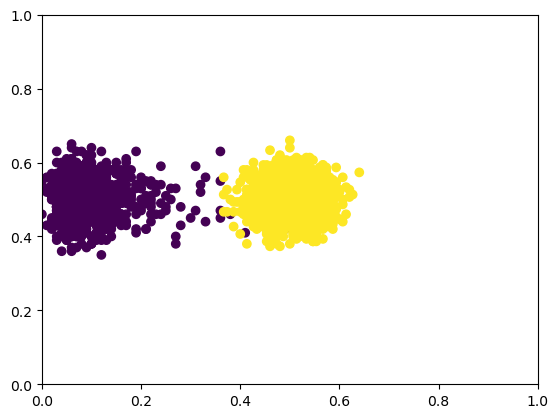

In [7]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [8]:
kmeans = KMeans(n_clusters=2, random_state=seed, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [9]:
cluster_centers = torch.tensor(cluster_centers)#.float().detach()
print(cluster_centers)

tensor([[0.5001, 0.5001],
        [0.0872, 0.5022]])


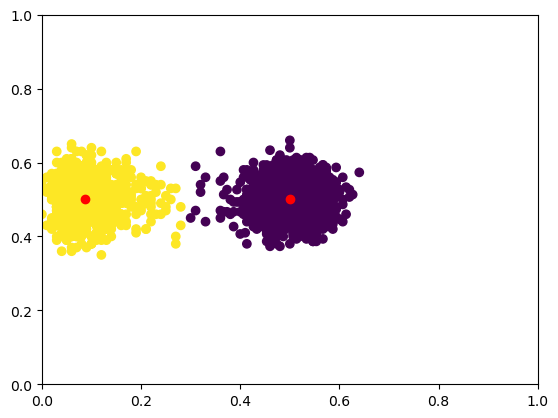

In [10]:
NV_S1 = NV[:,0]
NV_S2 = NV[:,1]

DP_S1 = DP[:,0]
DP_S2 = DP[:,1]
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c = cluster, label = "Original data")
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c = 'r')

In [242]:
delta = torch.tensor([0.1,0.9])
alpha = 0.1
a_beta = torch.ones(2)
b_beta = torch.ones(2)
probs = torch.tensor([0.3997, 0.6000])
delta_pareto = torch.log(delta[0]) + BoundedPareto(0.001, alpha, 1).log_prob(probs)
delta_beta = torch.log(delta[1]) + dist.Beta(a_beta, b_beta).log_prob(probs)
print(delta_pareto)
# torch.concat((delta_pareto, delta_beta), dim = 0)
torch.stack((delta_pareto, delta_beta), dim=0)

tensor([-4.2872, -4.7340])


tensor([[-4.2872, -4.7340],
        [-0.1054, -0.1054]])

In [26]:
a_beta = torch.ones(1)
b_beta = torch.ones(1)
print(cluster_centers)
dist.Beta(a_beta, b_beta).log_prob(cluster_centers)
# BoundedPareto(0.001, 2, 1).log_prob(cluster_centers)

tensor([[0.5001, 0.5001],
        [0.0872, 0.5022]])


tensor([[0., 0.],
        [0., 0.]])

In [11]:
def log_beta_par_mix(probs, delta, alpha, a_beta, b_beta):
    delta_pareto = torch.log(delta[:, 0]) + BoundedPareto(0.001, alpha, 1).log_prob(probs) # 1x2 tensor
    delta_beta = torch.log(delta[:, 1]) + dist.Beta(a_beta, b_beta).log_prob(probs) # 1x2 tensor
    
    return log_sum_exp(torch.stack((delta_pareto, delta_beta), dim=0)) # creates a 2x2 tensor with torch.stack because log_sum_exp has dim=0

In [12]:
# Rewrite binomial likelihood for the multidimensional case
# Multidimensional binomial log likelihood
def m_total_lk(probs, probs_pareto, alpha, a_beta, b_beta, DP, weights, delta, K, NV):
    lk = torch.ones(K, len(NV)) # matrix with K rows and as many columns as the number of data
    if K == 1:
        return torch.log(weights) + (dist.Binomial(total_count=DP, probs = probs).log_prob(NV) + log_beta_par_mix(probs, delta[0, :, :], alpha, a_beta, b_beta)).sum(axis=1) # simply does log(weights) + log(density)
    for k in range(K):
        # print(a_beta)
        # print(b_beta)
        # print(alpha)
        lk[k, :] = torch.log(weights[k]) + (dist.Binomial(total_count=DP, probs=probs[k, :]).log_prob(NV) + log_beta_par_mix(probs[k, :], delta[k, :, :], alpha[k, :], a_beta, b_beta)).sum(axis=1) # sums over the data dimensions (columns)
                                                                                                                 # put on each column of lk a different data; rows are the clusters
    return lk

def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

In [13]:
pyro.set_rng_seed(12)
K = 3
D = 4
with pyro.plate("plate_dims", D):
    with pyro.plate("plate_probs", K):
            # Prior for the Beta-Pareto weights
        delta = pyro.sample("delta", dist.Dirichlet(torch.ones(2))) # delta is a K x D x 2 tensor
print(delta)
print(delta[1, :, :][:, 0])

tensor([[[0.9008, 0.0992],
         [0.9307, 0.0693],
         [0.5407, 0.4593],
         [0.8528, 0.1472]],

        [[0.4498, 0.5502],
         [0.9430, 0.0570],
         [0.5763, 0.4237],
         [0.6125, 0.3875]],

        [[0.3506, 0.6494],
         [0.9420, 0.0580],
         [0.4011, 0.5989],
         [0.4980, 0.5020]]])
tensor([0.4498, 0.9430, 0.5763, 0.6125])


In [14]:
def m_beta_pareto_model(NV, DP, K):
    D = NV.shape[1] # number of dimensions (samples)

    # Prior for the mixing weights
    weights = pyro.sample("weights", dist.Dirichlet(torch.ones(K)))

    with pyro.plate("plate_dims", D):
        with pyro.plate("plate_probs", K):
            # Prior for the Beta-Pareto weights
            delta = pyro.sample("delta", dist.Dirichlet(torch.ones(2))) # delta is a K x D x 2 tensor
            
            a_beta = torch.ones(1) # a_beta is a K x D tensor
            b_beta = torch.ones(1) # b_beta is a K x D tensor
            # assume Beta prior for the success probabilities
            probs_beta = pyro.sample("probs_beta", dist.Beta(a_beta, b_beta)) # probs_beta is a K x D tensor
        
            alpha = pyro.sample("alpha_pareto", dist.LogNormal(0, 100)) # alpha is a K x D tensor
            probs_pareto = pyro.sample("probs_pareto", BoundedPareto(0.001, alpha, 1)) # probs_pareto is a K x D tensor

    # Data generation
    with pyro.plate("plate_data", len(NV)):
        pyro.factor("lik", log_sum_exp(m_total_lk(probs_beta, probs_pareto, alpha, a_beta, b_beta, DP, weights, delta, K, NV)).sum()) # .sum() sums over the data because we have a log-likelihood

In [15]:
torch.ones(2, K, D)

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [16]:
def m_beta_pareto_guide(NV, DP, K):
    D = NV.shape[1] # number of dimensions (samples)
    
    weights_param = pyro.param("weights_param", lambda: dist.Dirichlet(torch.ones(K)).sample(), constraint=constraints.simplex)
    pyro.sample("weights", dist.Delta(weights_param).to_event(1))

    # delta_param = pyro.param("delta_param", lambda: dist.Dirichlet(torch.ones(2)).sample(), constraint=constraints.simplex)
    delta_param = pyro.param("delta_param", lambda: dist.Dirichlet(torch.ones(K, D, 2)).sample(), constraint=constraints.simplex)
    # pyro.sample("delta", dist.Delta(delta_param).to_event(1))

    # alpha_param = pyro.param("alpha_param", torch.tensor([[0.8, 0.8], [0.8, 0.8]]), constraint=constraints.positive) # Use 0.8 as starting value
    alpha_param = pyro.param("alpha_param", torch.ones((K,D)), constraint=constraints.positive) # Use 0.8 as starting value

    probs_param = pyro.param("probs_param", cluster_centers, constraint=constraints.interval(0.,1.))
    
    print(probs_param)
    
    with pyro.plate("plate_dims", D):
        with pyro.plate("plate_probs", K):       
            pyro.sample("alpha_pareto", dist.Delta(alpha_param)) # here because we need to have K x D samples
            pyro.sample("probs_pareto", BoundedPareto(0.001, alpha_param, 1))
            pyro.sample("probs_beta", dist.Delta(probs_param))
            pyro.sample("delta", dist.Delta(delta_param).to_event(1)) # not sure

In [17]:
# Run inference
pyro.clear_param_store()
seed = 123
pyro.set_rng_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
svi = pyro.infer.SVI(m_beta_pareto_model, m_beta_pareto_guide, pyro.optim.Adam({"lr": 0.001}), pyro.infer.TraceGraph_ELBO())
num_iterations = 2000
for i in range(num_iterations):
    loss = svi.step(NV, DP, K=2)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

tensor([[0.5001, 0.5001],
        [0.0872, 0.5022]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 76576440.0
tensor([[0.4998, 0.4998],
        [0.0871, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.4997, 0.4998],
        [0.0871, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.4997, 0.4999],
        [0.0870, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.4998, 0.5000],
        [0.0869, 0.5023]], grad_fn=<ClampBackward1>)
tensor([[0.4999, 0.5000],
        [0.0868, 0.5023]], grad_fn=<ClampBackward1>)
tensor([[0.4999, 0.5000],
        [0.0867, 0.5023]], grad_fn=<ClampBackward1>)
tensor([[0.5000, 0.4999],
        [0.0867, 0.5023]], grad_fn=<ClampBackward1>)
tensor([[0.5000, 0.4999],
        [0.0866, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.4999, 0.4999],
        [0.0865, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.4999, 0.4999],
        [0.0864, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.4998, 0.4999],
        [0.0864, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.4998, 0.50

In [18]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.6752, 0.3248], grad_fn=<DivBackward0>)
delta_param tensor([[[0.0032, 0.9968],
         [0.0305, 0.9695]],

        [[0.1038, 0.8962],
         [0.0477, 0.9523]]], grad_fn=<DivBackward0>)
alpha_param tensor([[0.1764, 0.1870],
        [0.2270, 0.1960]], grad_fn=<AddBackward0>)
probs_param tensor([[0.4998, 0.5000],
        [0.0845, 0.5025]], grad_fn=<ClampBackward1>)


In [19]:
# Extract the learned parameters
param_store = pyro.get_param_store()
params = {}
params["probs_bin"] = param_store["probs_param"].clone().detach()
params["weights"] = param_store["weights_param"].clone().detach()
params["delta"] = param_store["delta_param"].clone().detach()
params["alpha_pareto"] = param_store["alpha_param"].clone().detach()

print("Probabilities of success binomial components: ", params["probs_bin"]) # First row = component 1, second row = component 2
print("Mixing proportions: ", params["weights"])
print("Delta: ", params["delta"])
print("Alpha pareto: ", params["alpha_pareto"])

Probabilities of success binomial components:  tensor([[0.4998, 0.5000],
        [0.0845, 0.5025]])
Mixing proportions:  tensor([0.6752, 0.3248])
Delta:  tensor([[[0.0032, 0.9968],
         [0.0305, 0.9695]],

        [[0.1038, 0.8962],
         [0.0477, 0.9523]]])
Alpha pareto:  tensor([[0.1764, 0.1870],
        [0.2270, 0.1960]])


In [20]:
# Rewrite binomial likelihood for the multidimensional case
# Multidimensional binomial log likelihood
def m_binomial_lk(probs, DP, weights, K, NV):
    lk = torch.ones(K, len(NV)) # matrix with K rows and as many columns as the number of data
    if K == 1:
        return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(NV).sum(axis=1) # simply does log(weights) + log(density)
    for k in range(K):
        lk[k, :] = torch.log(weights[k]) + dist.Binomial(total_count=DP, probs=probs[k, :]).log_prob(NV).sum(axis=1) # sums over the data dimensions (columns)
                                                                                                                 # put on each column of lk a different data; rows are the clusters
    return lk

In [253]:
# Now compute posterior assignment probabilities given the learned parameters
K = 2
lks = m_binomial_lk(probs=params['probs_bin'], DP = DP, weights=params['weights'], K = K, NV = NV) # Compute log-likelihood for each data in each cluster
res = torch.zeros(K, len(NV))

In [254]:
norm_fact = log_sum_exp(lks) # sums over the different cluster -> array of size len(NV)
for k in range(len(res)): # iterate over the clusters
    lks_k = lks[k] # take row k -> array of size len(NV)
    res[k] = torch.exp(lks_k - norm_fact)
params["cluster_probs"] = res

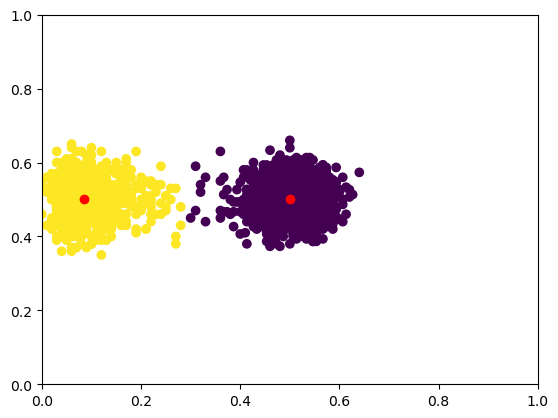

In [255]:
clust =  torch.argmax(params["cluster_probs"], dim = 0)
NV_S1 = NV[:,0]
NV_S2 = NV[:,1]

DP_S1 = DP[:,0]
DP_S2 = DP[:,1]

plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c = cluster, label = "Original data")
plt.scatter(params['probs_bin'][:, 0], params['probs_bin'][:, 1], c = 'r')